In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import h5py

import os
from dotenv import load_dotenv
load_dotenv()

from data_manipulation.reading_util import filter_unwanted_seqs

2023-09-08 11:41:33.253271: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-08 11:41:33.416988: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-08 11:41:33.418321: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 11:41:34.443683: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Reading in esm2 embeddings

In [2]:
def read_esm2(path_to_enzyme_esm2: str):
    """
    Reads in esm2 type embeddings and extracts headers and embeddings (as two separate lists)
    :param path_to_enzyme_esm2: Path to esm2
    :return: headers: list[str], embeddings: list[np.array]
    """

    with h5py.File(path_to_enzyme_esm2) as hdf_handle:
        headers = list(hdf_handle.keys())
        embeddings = [np.array(emb) for header, emb in hdf_handle.items()]

        return pd.DataFrame(data={"Entry":headers, "Embedding":embeddings})


def read_data(path_to_enzyme_esm2: str, path_to_enzyme_splitX_csv: str, test_data: bool):
    """
    Reads in esm2 and splitX.csv
    :param path_to_enzyme_esm2: Absolute path to enzyme_esm2_splitX
    :param path_to_enzyme_splitX_csv: Absolute path to enzyme_splitX.csv
    :param test_data: Should be true when using test_data (has to do with the separator when reading in the csv file)
    :return: A dataframe (representing splitX.csv), headers of esm2 (list), esm2 embeddings (list)
    """
    embedding_df = read_esm2(path_to_enzyme_esm2=path_to_enzyme_esm2)
    print("LOG: Reading ESM2 DONE")
    
    if not test_data:
        enzyme_csv = pd.read_csv(path_to_enzyme_splitX_csv, header=0, sep='\t', index_col=0)
    else:
        enzyme_csv = pd.read_csv(path_to_enzyme_splitX_csv, header=0, sep=',')
        
    print("LOG: Reading CSV DONE")


    # control
    print("LOG: Enzymes in SplitX.csv:", len(enzyme_csv))
    print("LOG: Embeddings in SplitX_esm2:", len(embedding_df))
    print("LOG: Reading in data: DONE")
    return [embedding_df, enzyme_csv]


### Creating X and y
#### Reading in data (splitX.csv and esm2_splitX)

In [3]:
enzyme_metadata_path = os.getenv("METADATA_CSV")
esm2_enzymes_path = os.getenv("ESM2_ENZYMES_SPLIT_100")
emb_df, enz_df = read_data(path_to_enzyme_splitX_csv=enzyme_metadata_path, path_to_enzyme_esm2=esm2_enzymes_path, test_data=False)

LOG: Reading ESM2 DONE
LOG: Reading CSV DONE
LOG: Enzymes in SplitX.csv: 224693
LOG: Embeddings in SplitX_esm2: 226505
LOG: Reading in data: DONE


#### Now we initialize X and y
This is still a really long process which scales bad...

In [4]:
X = []
y = []

for label in emb_df["Entry"]:
    number = enz_df.loc[enz_df["Entry"] == label,"EC number"]
    try: 
        ec = int(number.iat[0][0])-1 # since we always start counting from 0
        y.append(ec) # append label (1-7)
        X.append(emb_df.loc[emb_df["Entry"] == label, "Embedding"].values[0]) # append embedding
    except IndexError as e:
        print(label)
        
    
X = np.array(X)

A0A1U9X9N3
A3EZ53
A3EZ54
A7SG73
B2MUU6
B3A0L4
B3A0L6
B3A0N3
B3EWC6
B3EWG2
B3EWG7
B3EWG8
B3EWG9
B3EWI3
B3EWI9
B3EWP2
B3EWP6
B3EWQ8
B3EWR5
B8V7P3
C0HJB2
C0HJE2
C0HJE3
C0HJE4
C0HJH0
C0HJL9
C0HJM0
C0HJM6
C0HJP9
C0HJU3
C0HJW7
C0HK05
C0HK48
C0HKB1
C0HLB8
C0HLF7
C0HLL7
C0HLL8
C0HLM4
C0HLM5
C0HLQ4
C0HLQ6
C0HLT5
C0HLV0
C0HLV6
C0HLV7
C1IC45
C1IC46
C9WJD0
D2KKB4
D5KX81
H8ZW44
O03063
O03070
O03073
O03077
O03692
O03695
O03697
O03698
O03699
O03700
O03701
O03702
O03703
O03704
O03707
O03710
O03726
O03727
O03733
O03763
O03772
O03773
O03778
O03780
O03792
O03807
O03889
O03890
O03891
O03892
O03893
O03895
O04395
O08459
O08460
O08461
O08615
O13148
O18851
O18921
O19023
O19098
O19175
O21515
O21521
O30394
O30397
O30549
O30836
O30853
O30885
O32719
O32857
O32858
O33159
O33160
O33508
O33509
O33510
O33535
O33543
O33544
O33545
O33551
O33575
O33579
O33603
O33605
O33686
O33756
O33783
O35502
O35573
O35724
O35840
O36041
O42154
O42411
O42412
O44105
O46660
O50467
O54210
O54233
O54263
O54266
O54457
O57672
O62696
O62846
O6

### Control

In [5]:
print(len(y))
print(len(X))

224693
224693


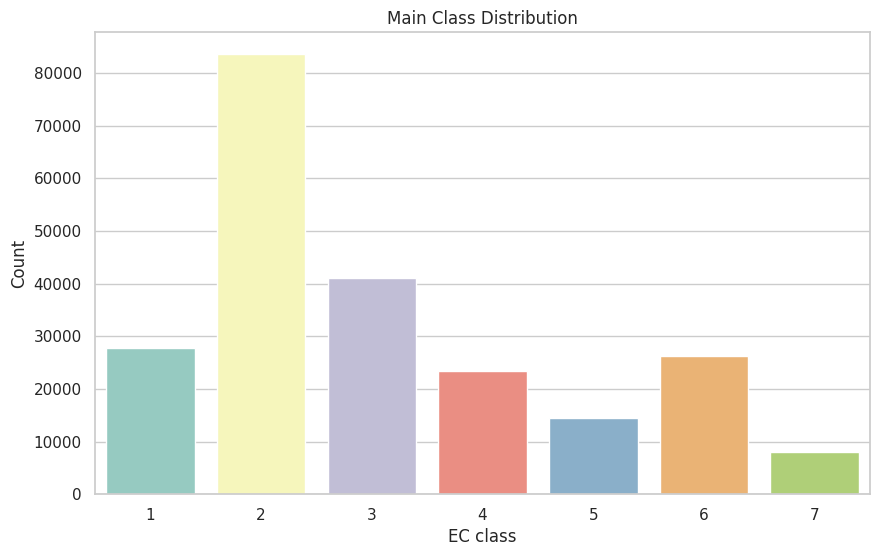

In [6]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.countplot(x=y, palette="Set3")
plt.xticks([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7])

# Add labels and title
plt.xlabel("EC class")
plt.ylabel("Count")
plt.title("Main Class Distribution")

# Show the plot
plt.show()

## Creating and training our CNN

### Splitting data into train and test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)
print(y_test_encoded[0])

[0. 0. 0. 1. 0. 0. 0.]


In [8]:
# This is used for stopping the training precess in advance, if our model starts to overfit our training data
earl_stop = tf.keras.callbacks.EarlyStopping(patience=5)

In [9]:
# Initializing the model
model = tf.keras.models.Sequential()

# Adding input layer
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2560,)))

# Adding hidden layer
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Finally adding output layer using softmax as activation function
model.add(tf.keras.layers.Dense(units=7, activation='softmax'))  # Using softmax for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [10]:
# Training the model
model.fit(x=X_train, y=y_train_encoded, epochs=5, validation_data=(X_test, y_test_encoded), callbacks = [earl_stop])

Epoch 1/5


2023-09-08 13:04:49.882235: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1610598400 exceeds 10% of free system memory.


4916/4916 [==============================] - ETA: 0s - loss: 0.3848

2023-09-08 13:05:51.502651: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 690257920 exceeds 10% of free system memory.


4916/4916 [==============================] - 66s 13ms/step - loss: 0.3848 - val_loss: 0.0959
Epoch 2/5
4916/4916 [==============================] - 65s 13ms/step - loss: 0.1694 - val_loss: 0.0726
Epoch 3/5
4916/4916 [==============================] - 64s 13ms/step - loss: 0.1326 - val_loss: 0.0622
Epoch 4/5
4916/4916 [==============================] - 64s 13ms/step - loss: 0.1138 - val_loss: 0.0518
Epoch 5/5
4916/4916 [==============================] - 64s 13ms/step - loss: 0.1007 - val_loss: 0.0472


# Evaluation

<Figure size 1000x600 with 0 Axes>

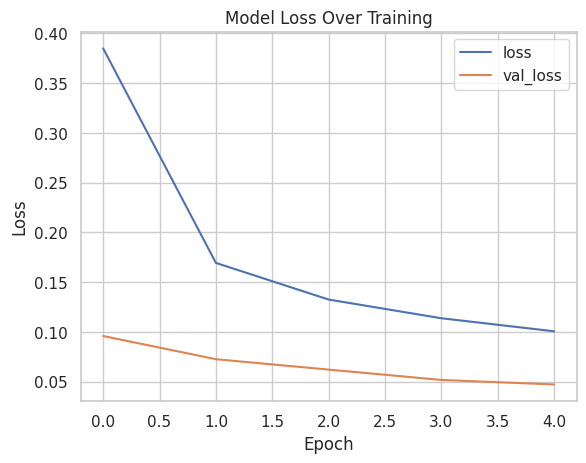

In [11]:
# Plotting loss (loss on train_data) and val_loss (loss on validation_data)
model_loss = pd.DataFrame(model.history.history)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
model_loss.plot()

plt.title('Model Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [12]:
predictions = np.argmax(model.predict(X_test), axis=-1) # for multi class classification (using softmax)

  22/2107 [..............................] - ETA: 5s  

2023-09-08 13:10:20.004988: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 690257920 exceeds 10% of free system memory.


2107/2107 [==============================] - 7s 3ms/step


In [13]:
counter = 0
for x,y in zip(y_test,predictions):
    if x == y:
        counter+=1
print("Correct predictions: ", counter)
print("Total samples predicted:", len(y_test))

Correct predictions:  66499
Total samples predicted: 67408


In [14]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      8366
           1       0.98      1.00      0.99     25095
           2       0.99      0.98      0.98     12436
           3       0.99      0.96      0.97      6964
           4       0.98      0.97      0.98      4315
           5       1.00      0.99      1.00      7764
           6       1.00      0.99      0.99      2468

    accuracy                           0.99     67408
   macro avg       0.99      0.98      0.99     67408
weighted avg       0.99      0.99      0.99     67408


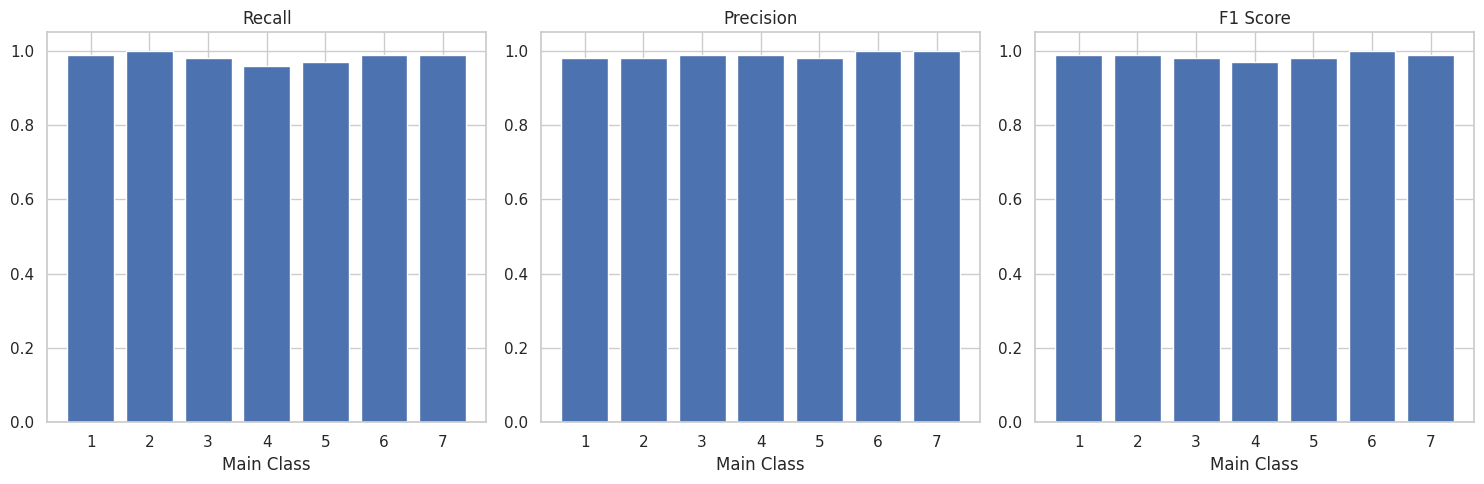

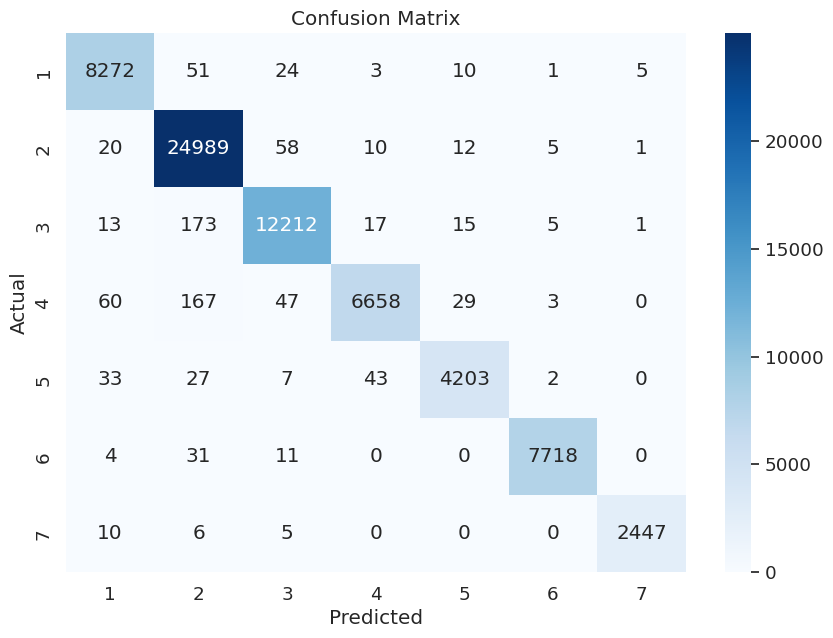

In [16]:
def plot_report(report, y , predictions):
    """
    Plots results of model
    :param report: Report of model
    """
    
    class_0_metrics = report.split('\n')[2].split()[1:]
    class_1_metrics = report.split('\n')[3].split()[1:]
    class_2_metrics = report.split('\n')[4].split()[1:]
    class_3_metrics = report.split('\n')[5].split()[1:]
    class_4_metrics = report.split('\n')[6].split()[1:]
    class_5_metrics = report.split('\n')[7].split()[1:]
    class_6_metrics = report.split('\n')[8].split()[1:]

    metrics = [class_0_metrics,
               class_1_metrics,
               class_2_metrics,
               class_3_metrics,
               class_4_metrics,
               class_5_metrics,
               class_6_metrics
               ]
    i = 1
    precs = []
    recs = []
    f1_s = []
    for class_m in metrics:
        precision = float(class_m[0])
        recall = float(class_m[1])
        f1_score = float(class_m[2])
        precs.append(precision)
        recs.append(recall)
        f1_s.append(f1_score)
        i+=1

    class_names = [1,2,3,4,5,6,7]

    # Create subplots for accuracy, precision, and F1
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Plot accuracy for each class
    ax1.bar(class_names, recs)
    ax1.set_title("Recall")
    ax1.set_xlabel("Main Class")


    # Plot precision for each class
    ax2.bar(class_names, precs)
    ax2.set_title("Precision")
    ax2.set_xlabel("Main Class")

    # Plot F1 score for each class
    ax3.bar(class_names, f1_s)
    ax3.set_title("F1 Score")
    ax3.set_xlabel("Main Class")

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()


    conf_matrix = confusion_matrix(y, predictions)

    # Create a confusion matrix heatmap
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.2)  # Adjust font size as needed
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

plot_report(report, y_test, predictions)

In [15]:
model.save("cnn_v5_split100.keras")

# Importing and using my model

## 2. Predict new data
The data needs to be the same shape as the training/test data used to train the model.
The unlabeled embeddings need to be imported into a dataframe and then we need to create a feature column for each 
value of the embedding.


In [52]:
def validate_on_test_data(path_to_enzyme_test_csv: str, path_to_enzyme_test_esm2: str, path_to_cnn_model):
    
    # Load model and test data
    model = tf.keras.models.load_model(path_to_cnn_model)

    emb_test_df, enz_test_df = read_data(path_to_enzyme_splitX_csv=path_to_enzyme_test_csv, 
                                         path_to_enzyme_esm2=path_to_enzyme_test_esm2, test_data=True)

    # Init X and y
    X = []
    y = []

    for label in emb_test_df["Entry"]:
        number = enz_test_df.loc[enz_test_df["Entry"] == label,"EC number"]
        ec = int(number.iat[0][0])-1 # since we always start counting from 0
        y.append(ec) # append label (1-7)
        X.append(emb_test_df.loc[emb_test_df["Entry"] == label, "Embedding"].values[0]) # append embedding

    X = np.array(X)
    
    print("LOG: Adding labels: DONE")


    print("\n\n============================================= PREDICTING TEST DATA =============================================\n\n") 
    
    predictions = np.argmax(model.predict(X), axis=-1) # for multi class classification (using softmax)
   
    print("LOG: Making predictions: DONE")
    
    # Evaluation
    counter = 0
    for label, predict_label in zip(y,predictions):
        if label == predict_label:
            counter+=1
            
    print("LOG: Correct predictions: ", counter)
    print("LOG: Total samples predicted:", len(y))


    report = classification_report(y, predictions)
    print(report)
    plot_report(report, y, predictions)


    # Overview of class dist
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    sns.countplot(x=y, palette="Set3")

    plt.xticks([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7])
    plt.xlabel("EC class")
    plt.ylabel("Count")
    plt.title("Main Class Distribution")

    plt.show()



LOG: Reading ESM2 DONE
LOG: Reading CSV DONE
LOG: Enzymes in SplitX.csv: 7212
LOG: Embeddings in SplitX_esm2: 7212
LOG: Reading in data: DONE
LOG: Adding labels: DONE


============================================= PREDICTING TEST DATA =============================================


226/226 [==============================] - 1s 2ms/step
LOG: Making predictions: DONE
LOG: Correct predictions:  6945
LOG: Total samples predicted: 7212
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       894
           1       0.98      0.98      0.98      2952
           2       0.96      0.98      0.97      2149
           3       0.92      0.88      0.90       515
           4       0.96      0.86      0.91       304
           5       0.95      0.94      0.95       233
           6       0.93      0.96      0.95       165

    accuracy                           0.96      7212
   macro avg       0.95      0.94      0.94      7212
weighted avg       0.9

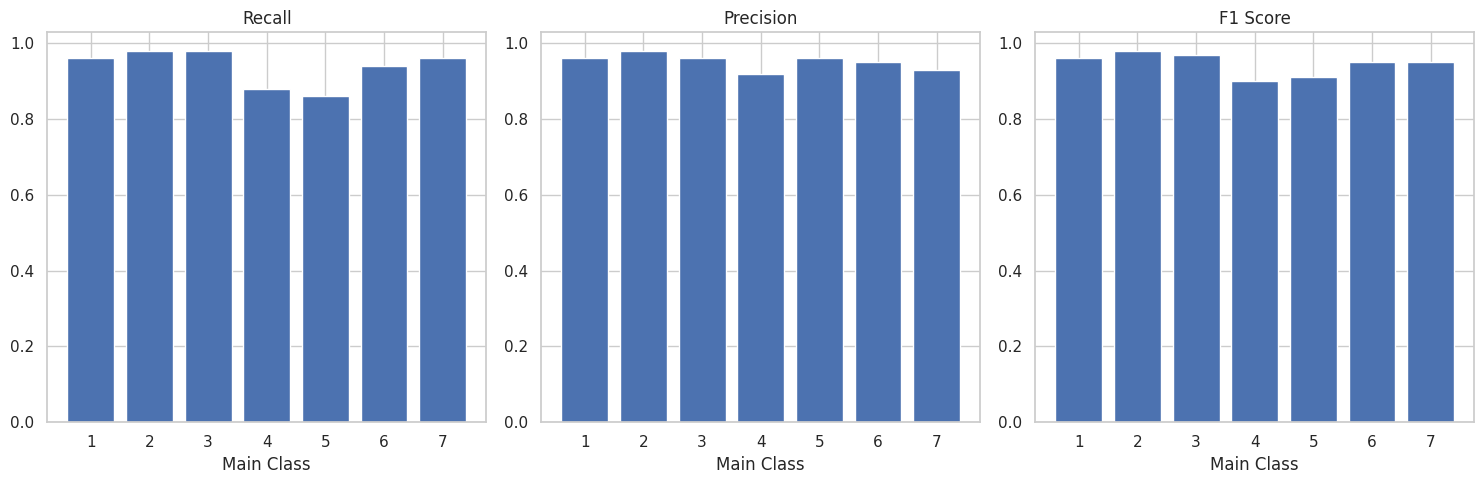

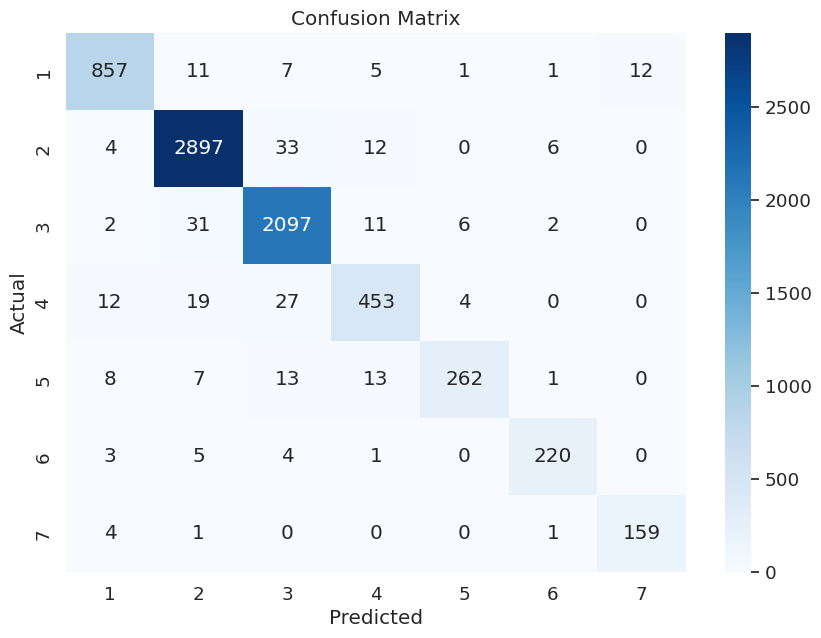

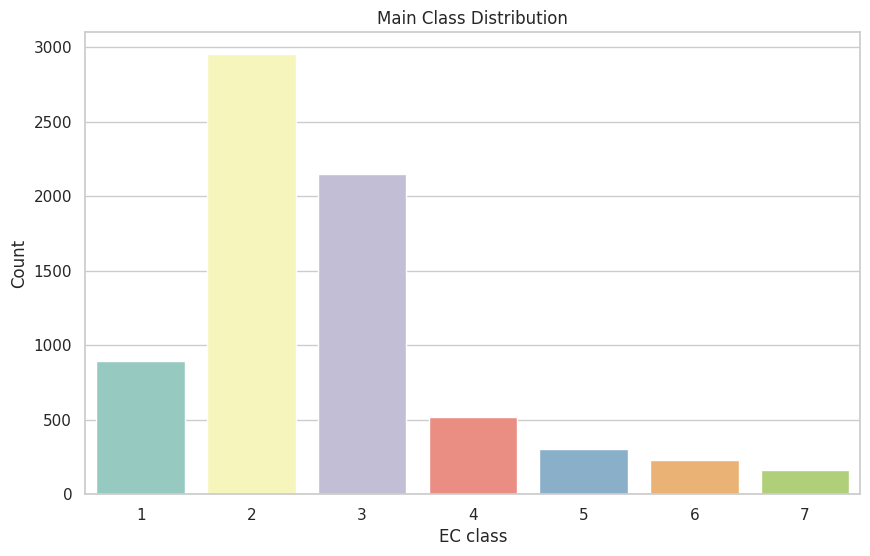

In [53]:
validate_on_test_data(path_to_enzyme_test_csv=os.getenv("CSV10_ENZYMES"),
                      path_to_enzyme_test_esm2=os.getenv("ESM2_ENZYMES_SPLIT_10"),
                      path_to_cnn_model="/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/cnn_v4.keras")